## 52 - Projection Magic

Watch video: [YouTube](https://www.youtube.com/watch?v=7YH-M7MSRF4)

In [1]:
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
from matplotlib import patheffects
from metpy.plots import colortables
from xarray.backends import NetCDF4DataStore
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
date = datetime.datetime.utcnow()
channel = 8
region = 'CONUS'

In [4]:
cat = TDSCatalog(f'http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/{region}/Channel{channel:02d}/{date:%Y%m%d}/catalog.xml')

In [5]:
cat.datasets[-5:]

[OR_ABI-L2-CMIPC-M6C08_G16_s20240850646150_e20240850646150_c20240850646150.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20240850651150_e20240850651150_c20240850651150.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20240850656150_e20240850656150_c20240850656150.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20240850701150_e20240850701150_c20240850701150.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20240850706150_e20240850706150_c20240850706150.nc]

In [6]:
ds = cat.datasets[-1]
ds = ds.remote_access(service='OPENDAP')

In [7]:
ds = NetCDF4DataStore(ds)
ds = xr.open_dataset(ds)

In [8]:
ds

<xarray.Dataset> Size: 15MB
Dimensions:               (y: 1500, x: 2500)
Coordinates:
    time                  datetime64[ns] 8B ...
  * y                     (y) float64 12kB 1.282e+05 1.282e+05 ... 4.427e+04
  * x                     (x) float64 20kB -1.013e+05 -1.013e+05 ... 3.861e+04
Data variables:
    fixedgrid_projection  int32 4B ...
    Sectorized_CMI        (y, x) float32 15MB ...
Attributes: (12/30)
    title:                       Sectorized Cloud and Moisture Imagery for th...
    ICD_version:                 GROUND SEGMENT (GS) TO ADVANCED WEATHER INTE...
    Conventions:                 CF-1.6
    channel_id:                  8
    central_wavelength:          6.19
    abi_mode:                    6
    ...                          ...
    pixel_y_size:                2.0
    satellite_latitude:          0.0
    satellite_longitude:         -75.0
    satellite_altitude:          35786023.0
    created_by:                  ldm-alchemy
    product_tiles_received:      15

In [10]:
data = ds.metpy.parse_cf('Sectorized_CMI')
proj = data.metpy.cartopy_crs

In [11]:
data

<xarray.DataArray 'Sectorized_CMI' (y: 1500, x: 2500)> Size: 15MB
[3750000 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 8B ...
  * y          (y) float64 12kB 4.588e+06 4.586e+06 ... 1.586e+06 1.584e+06
  * x          (x) float64 20kB -3.626e+06 -3.624e+06 ... 1.38e+06 1.382e+06
    metpy_crs  object 8B Projection: geostationary
Attributes:
    standard_name:                                          brightness_temper...
    units:                                                  kelvin
    grid_mapping:                                           fixedgrid_projection
    valid_min:                                              0
    valid_max:                                              4095
    percent_good_pixel_qf:                                  1.0
    percent_conditionally_usable_pixel_qf:                  0.0
    percent_out_of_range_pixel_qf:                          0.0
    percent_no_value_pixel_qf:                              0.0
    percent_focal_plane_temperature_threshold_exceeded_qf:  0.0
    maximum_focal_plane_temperature:                        59.923336
    _ChunkSizes:                                            [512 512]

In [23]:
proj

<Projected CRS: +proj=geos +a=6378137.0 +b=6356752.31414 +lon_0=-7 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: Unknown based on GRS 1980 ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

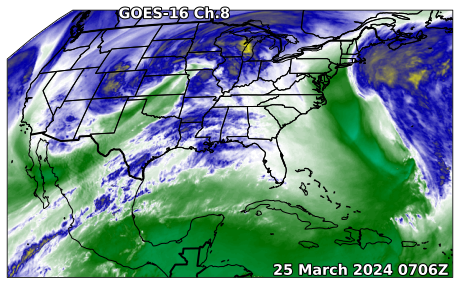

In [27]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=proj)
im = ax.imshow(data, extent=(data['x'].min(), data['x'].max(), data['y'].min(), data['y'].max()), origin='upper')
wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS', 195, 265)
im.set_cmap(wv_cmap)
im.set_norm(wv_norm)
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='black')
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.coastlines(resolution='50m', color='black')
timestamp = datetime.datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
text_time = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'), ha='right', transform=ax.transAxes, color='white', fontsize='x-large', weight='bold')
text_channel = ax.text(0.5, 0.97, f'GOES-16 Ch.{channel}', ha='right', transform=ax.transAxes, color='white', fontsize='x-large', weight='bold')
outline_effect = [patheffects.withStroke(linewidth=2, foreground='black')]
text_time.set_path_effects(outline_effect)
text_channel.set_path_effects(outline_effect)
plt.show()